# Interactive filtering of predicted ligands

There are many techniques to generate a ranked list of molecules having some desirable property, such as activity at a protein target of interest. The problem here is that the number of predicted ligands could easily exceed the synthesis and assay budget. Further issues are that some proportion of the ligands: 

* are difficult to synthesize (such as some natural products)
* have toxic off-target activity
* closely resemble existing ligands (meaning they fall under an existing patent and are not good drug candidates)
* are chemically unstable
* have 'bad' motifs like carboxylic acids that will be quickly metabolised

The list could go on, but basically ranked predictions should be accompanied by some method of filtering. A large-scale example of this is the [Ultra-large library docking for discovering new chemotypes](https://doi.org/10.1038/s41586-019-0917-9). It usually involves some visual inspection by a medicinal chemist or pharmacologist as well as automated filtering. 


This page demonstrates how to do this in an interactive way using RDKit and a Jupyter notebook. It uses [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html), so if you don't have that then install and enable first:

```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

For synthetic accessibility scores, you'll also need `sascorer.py` which is available [here](https://github.com/rdkit/rdkit/tree/master/Contrib/SA_Score)


If you don't want to install anything or run a notebook, the results look something like this:
![example](./filter_example.gif)



In [1]:
#imports:
import pandas as pd
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdFingerprintGenerator, PandasTools, Descriptors, FilterCatalog
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem.FilterCatalog import *

import sascorer
from rdkit.Chem.Descriptors import qed

#for clustering (not essential:)
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

Here I'm using a random selection of ligands as a stand-in for a real ranked list. I'm also using some randomly selected ligands for the known positives at an imaginary target-of-interest:

In [2]:
predicted = pd.read_csv('random_predicted.csv')
true_pos = pd.read_csv('random_known.csv')

##Adding a 'molecules' column using rdkit pandastools:
PandasTools.AddMoleculeColumnToFrame(predicted,'canonical_smiles','molecules')
PandasTools.AddMoleculeColumnToFrame(true_pos,'canonical_smiles','molecules')


The below adds a bunch of descriptors to the `predicted` dataframe, such as:
* highest similarity to known true positives
* synthetic accessibility score
* drug-likeness
* a bunch of PAINS/NIH/BRENK filters helpfully available in rdkit

you can easily add your own like logp, molwt, fragments (i.e. carboxylic acids using `Descriptors.fr_COO`), tpsa, etc...


In [3]:
#generate fingerprints of predicted ligands and known ligands:
gen_mo = rdFingerprintGenerator.GetMorganGenerator(fpSize=2048, radius=2)
predicted_fps = [gen_mo.GetFingerprint(mol) for mol in predicted['molecules']]
true_fps = [gen_mo.GetFingerprint(mol) for mol in true_pos['molecules']]

#create a list holding the highest similarity to a known ligand.
similarities= list()
for count, mol in enumerate(predicted_fps):
    tanimoto_values = ([DataStructs.TanimotoSimilarity(mol, i) for i in true_fps])
    index_of_highest = np.argmax(tanimoto_values)
    similarities.append(tanimoto_values[index_of_highest])
    
#create a list holding the 'synthetic accessibility score'
#reference: https://doi.org/10.1186/1758-2946-1-8
#module code is in: https://github.com/rdkit/rdkit/tree/master/Contrib/SA_Score
sa_score = [sascorer.calculateScore(i) for i in list(predicted['molecules'])]


#create a list holding the QED drug-likeness score
#reference: https://doi.org/10.1038/nchem.1243
qeds = [qed(mol) for mol in predicted['molecules']]



#create a list holding logp:
logp = [Descriptors.MolLogP(m) for m in predicted['molecules']]


#filter catalog usage instructions are here: https://github.com/rdkit/rdkit/pull/536
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog(params)
brenk = np.array([catalog.HasMatch(m) for m in predicted['molecules']])


#add these lists as columns to the 'predicted' pd.DataFrame
predicted['similarities']=similarities
predicted['sa_score']=sa_score
predicted['qeds']=qeds
predicted['logp']=logp




,instance_id,canonical_smiles,molecules,similarities,sa_score,qeds,logp
0,CHEMBL1384221,FC(F)(F)c1cccc(c1)C(=O)c2c[nH]c(c2)C(=O)NCCCN3CCOCC3,,0.326923,2.398588,0.544857,2.71660
1,CHEMBL3319491,CC(Nc1cc(F)cc(Cl)c1)C2=CC(=CN3C(=O)C=C(N=C23)N4CCOCC4)C(=O)N(C)C,,0.305085,3.340177,0.612784,3.19850
2,CHEMBL183903,C[C@@H]1OC(=O)[C@H]2C[C@H]3CCCC[C@@H]3C(CCC4CCC(C)(C)N4C)[C@@H]12,,0.203883,4.735916,0.696426,4.64340
3,CHEMBL3702250,CN(C)CC#CCNC(=O)c1sc2ncnc(Nc3ccc(F)cc3OC(CF)CF)c2c1C,,0.310078,3.218455,0.442811,3.86362
4,CHEMBL62778,COc1ccc2c(c1)nc(N3CCNCC3)n2Cc4ccccc4,,0.326087,2.069884,0.801327,2.50280

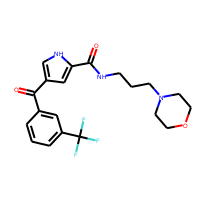
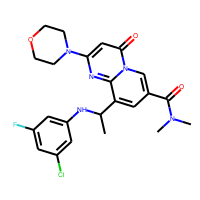
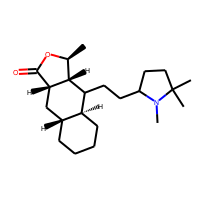
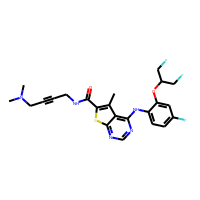
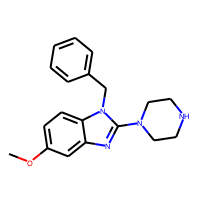

In [4]:
predicted.head()

# Make it interactive

This boils down to building a mask based on your chosen level of the above parameters, which is then used to filter the `predicted` list and return the remaining ranked hits. The function returns the rdkit `Draw.MolsToGridImage` to visualize the remaining molecules. 

Instructions:
- Set `similarity` lower to filter more ligands. Setting it to `1` returns all ligands even if they are highly similar to the known true positives.
- Set `sa_score` higher to include more difficult-to-synthesize ligands
- Set `qeds` higher to return only the most beautiful, drug-like ligands. Lower to return all ligands. 
- Set `logp` lower to cut out more hydrophobic ligands. 


After this, it's up to the user to select their desired top `x` ligands. 


In [4]:
@interact
def get_top_ligands(similarity=(0.2, 1, 0.01), sa_score=4, qeds=0.25, logp=6, num_mols=(1, 25, 1)):
    shortlist_mask = ((predicted['similarities']<similarity) & 
                      (predicted['sa_score']<sa_score) &
                      (predicted['qeds'] > qeds) &
                      (predicted['logp']<logp) &
                      (~brenk) )

    return Draw.MolsToGridImage(predicted[shortlist_mask]['molecules'].iloc[:num_mols],
                                maxMols=num_mols,
                               molsPerRow=6)

interactive(children=(FloatSlider(value=0.6000000000000001, description='similarity', max=1.0, min=0.2, step=0…

# Bonus - cluster and return only the top-ranked scaffold per cluster

You don't want the hit list to be full of a single scaffold with different R groups. Better to test multiple scaffolds and increase the probability of discovering a new chemotype. Clustering first, and returning only the top-ranked hit, removes closely-related analogs.

I use sklearn's `AgglomerativeClustering` because it gives nice, single-scaffold clusters.  It's not so great on the randomly selected example because there aren't as many analogs but it's an OK demo. 

Instructions:
- Set `dist_threshold` lower to make fewer, bigger and more diverse clusters. Higher to make more clusters with each cluster more uniform. 

In [5]:
pairwise_distances_all = pairwise_distances(np.array(predicted_fps), metric='dice')

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


In [6]:
##This creates a new column with the cluster labels each time you reload the function below. 
def get_cluster_ids(clusterer, shortlist_mask):
    cluster_labels = list()
    count = 0
    for idx in range(len(shortlist_mask)):
        if shortlist_mask[idx]==True:
            cluster_labels.append(clusterer.labels_[count])
            count+=1
        else:
            cluster_labels.append(None)
    return cluster_labels


@interact
def get_top_ligands(similarity=(0.2, 1, 0.01), 
                    sa_score=4, 
                    qeds=0.25, 
                    logp=6, 
                    num_mols=(1, 25, 1),
                   dist_threshold=(0.1,1, 0.01)):
    
    shortlist_mask = ((predicted['similarities']<similarity) & 
                      (predicted['sa_score']<sa_score) &
                      (predicted['qeds'] > qeds) &
                      (predicted['logp']<logp) &
                      (~brenk) )
    
    clusterer = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=dist_threshold, 
                                affinity='precomputed', 
                                linkage='average')
    clusterer.fit(pairwise_distances_all[shortlist_mask])
    predicted['cluster_labels']=get_cluster_ids(clusterer, shortlist_mask)

    return Draw.MolsToGridImage(predicted[shortlist_mask].drop_duplicates(subset='cluster_labels',keep='first')['molecules'].iloc[:num_mols],
                                maxMols=num_mols,
                               molsPerRow=6)

interactive(children=(FloatSlider(value=0.6000000000000001, description='similarity', max=1.0, min=0.2, step=0…